# Yield Prediction using Molecular Mol2Vec Embeddings Condensation reactions

Found this dataset from a recent publication by a D.M. Makarov et al. (Journal of Computational Science 74 (2023) 102173) (https://doi.org/10.1016/j.jocs.2023.102173)

"""We considered pyrrole or dipyrromethane condensation reactions with various aldehydes, resulting in the production of boron(III) dipyrromethene or BODIPY (681 records). These reactions were retrieved from articles (see “Dataset reactions” and Scheme S1). Addi tionally, we used the reactions of the production of dipyrromethane (111 records) and porphyrins (457 records). All condensation reactions for dipyrromethanes and 213 reactions for porphyrins with various al dehydes were obtained in our laboratory. The remaining 244 reactions for the porphyrins synthesis were obtained from articles (see “Dataset reactions”). Our experimental dataset is based on a study of pyrrole condensation processes with aldehydes, using catalytic amounts of organic acids to produce ms-aryl- and ß-alkyl-substituted dipyrro methanes. """

The objective of this notebook is to introduce a method for predicting yield

As a beginner, there may be numerous opportunities for improvement in this notebook. I was largely inspired by the work of D.M. Makarov et al and the STEPHEN LEE's notebook (BELKA: Molecule Representations for ML Tutorial), and VLAD SKIN's notebook (Tutorial ML In Chemistry Research. RDkit & mol2vec)  thanks to them.

## Data

In [32]:
import pandas as pd
import numpy as np

In [33]:
pd.set_option('display.max_row', 211)
pd.set_option('display.max_columns',211)

In [34]:
# Téléchargement du Dataset 
DataFrame = r"C:\Users\loris\Desktop\IA_chemistry\Dipyrromethanes_condensation_reactions-main\Condensation_reactions - Copie.xlsx"

df = pd.read_excel(DataFrame)

df= df.copy()

print(df.shape)
df.head()

(1249, 4)


,SMILES,yield,Temperature,Ind
0,CC(C)(C)c1ccc(OCCCCOc2ccc(C(C)(C)C)cc2C=O)c(C=...,0.05,20,78
1,O=Cc1ccccc1OCCOC(=O)C#CC(=O)OCCOc1ccccc1C=O.c1...,1.00,40,909
2,c1cc[nH]c1.Cc1cc(C)c(C=O)c(C)c1.COC(=O)c1ccc(C...,2.00,20,747
3,CC(C)(C)c1ccc(OCCCCCOc2ccc(C(C)(C)C)cc2C=O)c(C...,2.10,20,77
4,Cc1ccc(-c2ccccc2C=O)cc1.Fc1c(F)c(F)c(C(c2ccc[n...,2.50,25,266


## Missing values

In [35]:
# Recherche des valeurs manquantes
missing_values = df.isnull().sum()
missing_values

SMILES         0
yield          0
Temperature    0
Ind            0
dtype: int64

## Target

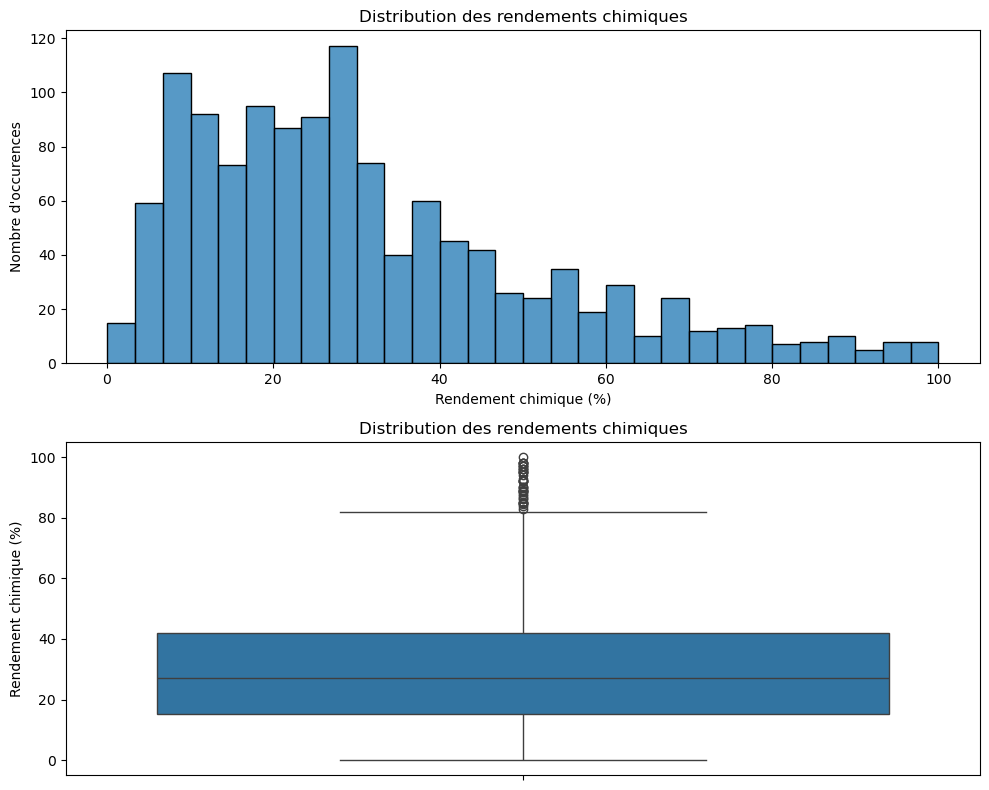

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Création de la figure et des axes pour les subplots
fig, axs = plt.subplots(2, 1, figsize=(10,8))

# Tracé de l'histogramme sur le premier subplot
sns.histplot(data=df, x='yield', bins=30, ax=axs[0])
axs[0].set_xlabel('Rendement chimique (%)')
axs[0].set_ylabel("Nombre d'occurences")
axs[0].set_title("Distribution des rendements chimiques")

# Tracé du boxplot sur le deuxième subplot
sns.boxplot(df["yield"], ax=axs[1])
axs[1].set_ylabel("Rendement chimique (%)")
axs[1].set_title("Distribution des rendements chimiques")

# Ajustement de l'espacement entre les subplots
plt.tight_layout()

# Affichage des graphiques 
plt.show()

## Obtenir des Mols

In [37]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [38]:
# Change le '>>' par '.', pour obtenir des Mols
def change_smile(df, columns_names):
    df['SMILES_2'] = df[columns_names].replace('>>', '.', regex=True)
    return df

In [39]:
# Transforme le SMILE en Mols
def Mols(df, columns_names):
    df["mols"] = pd.Series(df[columns_names]).apply(Chem.MolFromSmiles)
    return df

In [40]:
# Change le '>>' par '.', pour obtenir des Mols
df = change_smile(df, "SMILES")

In [41]:
# Transforme le SMILE en Mols
df = Mols(df, "SMILES_2")

[14:21:27] Explicit valence for atom # 26 H, 2, is greater than permitted
[14:21:27] Explicit valence for atom # 26 H, 2, is greater than permitted
[14:21:27] Explicit valence for atom # 0 O, 3, is greater than permitted
[14:21:27] Explicit valence for atom # 10 O, 3, is greater than permitted


### Enlève les dernières valeurs manquantes 

In [42]:
df.isnull().sum()

SMILES         0
yield          0
Temperature    0
Ind            0
SMILES_2       0
mols           4
dtype: int64

In [43]:
df = df.dropna()

In [44]:
df.isnull().sum()

SMILES         0
yield          0
Temperature    0
Ind            0
SMILES_2       0
mols           0
dtype: int64

## 💬 Mol2Vec Embeddings

Mol2Vec is a version of the widespread natural language processing (NLP) algorithm Word2vec, specifically adapted for molecular data. Mol2Vec represents molecules in a continuous vector space that captures chemical similarity in a mannner that is analagous to how Word2Vec captures semantic similarity between words. Mol2Vec treats chemical substructures (e.g. Morgan fingerprints with radius=1) as fundamental units of a 'molecular sentence', similar to how words are treated in NLP.

A Mol2Vec model pre-trained on 20 million molecules is available to generate 300 dimensional embeddings based on learned molecular vector representations. Below is example code to generate Mol2Vec embeddings

References:

Jaeger, S., Fulle, S., & Turk, S. (2018). Mol2vec: unsupervised machine learning approach with chemical intuition. Journal of Chemical Information and Modeling, 58(1), 27-35. 

Mol2Vec GitHub Repo

In [50]:
# for mol2vec
from gensim.models import word2vec
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec

In [51]:
mols = df["mols"]

In [52]:
# load pre-trained mol2vec model
mol2vec_url = 'https://github.com/samoturk/mol2vec/raw/master/examples/models/model_300dim.pkl'
mol2vec_model = word2vec.Word2Vec.load(mol2vec_url)

In [53]:
# generate molecular sentences
mol_sentences = mols.apply(lambda x: MolSentence(mol2alt_sentence(x, 1)))

[14:23:34] DEPRECATION WARNING: please use MorganGenerator
[14:23:34] DEPRECATION WARNING: please use MorganGenerator
[14:23:34] DEPRECATION WARNING: please use MorganGenerator
[14:23:34] DEPRECATION WARNING: please use MorganGenerator
[14:23:34] DEPRECATION WARNING: please use MorganGenerator
[14:23:34] DEPRECATION WARNING: please use MorganGenerator
[14:23:34] DEPRECATION WARNING: please use MorganGenerator
[14:23:34] DEPRECATION WARNING: please use MorganGenerator
[14:23:34] DEPRECATION WARNING: please use MorganGenerator
[14:23:34] DEPRECATION WARNING: please use MorganGenerator
[14:23:34] DEPRECATION WARNING: please use MorganGenerator
[14:23:34] DEPRECATION WARNING: please use MorganGenerator
[14:23:34] DEPRECATION WARNING: please use MorganGenerator
[14:23:34] DEPRECATION WARNING: please use MorganGenerator
[14:23:34] DEPRECATION WARNING: please use MorganGenerator
[14:23:34] DEPRECATION WARNING: please use MorganGenerator
[14:23:34] DEPRECATION WARNING: please use MorganGenerat

In [54]:
# version of sentences2vec() compatible with gensim v4.0 (source: https://github.com/samoturk/mol2vec/issues/14)
def sentences2vec(sentences, model, unseen=None):
    """Generate vectors for each sentence (list) in a list of sentences. Vector is simply a
    sum of vectors for individual words.
    
    Parameters
    ----------
    sentences : list, array
        List with sentences
    model : word2vec.Word2Vec
        Gensim word2vec model
    unseen : None, str
        Keyword for unseen words. If None, those words are skipped.
        https://stats.stackexchange.com/questions/163005/how-to-set-the-dictionary-for-text-analysis-using-neural-networks/163032#163032

    Returns
    -------
    np.array
    """
    
    keys = set(model.wv.key_to_index)
    vec = []
    
    if unseen:
        unseen_vec = model.wv.get_vector(unseen)

    for sentence in sentences:
        if unseen:
            vec.append(sum([model.wv.get_vector(y) if y in set(sentence) & keys
                       else unseen_vec for y in sentence]))
        else:
            vec.append(sum([model.wv.get_vector(y) for y in sentence 
                            if y in set(sentence) & keys]))
    return np.array(vec)

In [55]:
# generate vector embeddings from molecular sentences
mol2vec_embeddings = np.array([DfVec(x) for x in sentences2vec(mol_sentences, mol2vec_model, unseen='UNK')])
mol2vec_embeddings[:5]

array([(300,) dimensional vector, (300,) dimensional vector,
       (300,) dimensional vector, (300,) dimensional vector,
       (300,) dimensional vector], dtype=object)

In [56]:
mol2vec_embeddings.shape

(1245,)

In [57]:
mol2vec_embeddings[0]

(300,) dimensional vector

In [59]:
print('Molecular sentence:', mol2alt_sentence(df["mols"][1], radius=1))
print('\nMolSentence object:', MolSentence(mol2alt_sentence(df["mols"][1], radius=1)))
print('\nDfVec object:',DfVec(sentences2vec(MolSentence(mol2alt_sentence(df["mols"][1], radius=1)), mol2vec_model, unseen='UNK')))

Molecular sentence: ['864942730', '1510337516', '2246703798', '3945128999', '3217380708', '2394338241', '3218693969', '951226070', '3218693969', '98513984', '3218693969', '98513984', '3218693969', '951226070', '3217380708', '1135286194', '864674487', '2115476908', '2245384272', '4008337421', '2245384272', '4008337421', '864674487', '2222715027', '2246699815', '2633382186', '864942730', '1510328189', '2245900962', '4265016989', '2245900962', '4265016989', '2246699815', '2633382186', '864942730', '1510328189', '864674487', '2222715027', '2245384272', '4008337421', '2245384272', '4008337421', '864674487', '2115476908', '3217380708', '1135286194', '3218693969', '951226070', '3218693969', '98513984', '3218693969', '98513984', '3218693969', '951226070', '3217380708', '2394338241', '2246703798', '3945128999', '864942730', '1510337516', '3218693969', '98513984', '3218693969', '98513984', '3218693969', '951226070', '3217380708', '3579962709', '2245273601', '1348563946', '3217380708', '854632749

[14:30:35] DEPRECATION WARNING: please use MorganGenerator
[14:30:35] DEPRECATION WARNING: please use MorganGenerator
[14:30:35] DEPRECATION WARNING: please use MorganGenerator


In [93]:
# Convertir notre mol2vec_embeddings de shape 1245,1 en un tableau de 1245,300 (300 étant la dimension de notre vecteur) 
X = np.array([x.vec for x in mol2vec_embeddings])

In [94]:
X.shape

(1245, 300)

In [95]:
y = df['yield']
y.shape

(1245,)

## Model 

In [96]:
from tqdm import tqdm
from sklearn import metrics
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statistics import mean, stdev

In [97]:
X = pd.DataFrame(X)

In [98]:
X.shape

(1245, 300)

In [99]:
y = pd.DataFrame(y)

In [100]:
y.shape

(1245, 1)

In [101]:
# Convertir le DataFrame en une série
y_series = y.squeeze()

In [102]:
y_series.shape

(1245,)

### Model_random_forest_regression

In [103]:
def random_forest_regression(X, y):
    rmse_scores = []
    r2_scores = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
        model = RandomForestRegressor(n_estimators=120, max_depth=25)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_scores.append(rmse)
        r2 = r2_score(y_test, y_pred)
        r2_scores.append(r2)
        #print(f"Iteration {i}: RMSE = {rmse:.3f}, R^2  = {r2:.3f}")
    # Retourner la moyenne et l'écart-type des scores
    return mean(rmse_scores), stdev(rmse_scores), mean(r2_scores), stdev(r2_scores)
    
    print("\nAverage performance of test set at 10 split")
    print("Metric\tavg\tstdev")
    print("R^2\t%.2f\t%.2f" % (mean(r2_scores), stdev(r2_scores)))
    print("RMSE\t%.2f\t%.2f" % (mean(rmse_scores), stdev(rmse_scores)))

In [104]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from statistics import mean, stdev

def statistics_for_the_training_set_with_5CV_RFR(X, y):
    r2_scores = []
    rmse_scores = []
    
    for i in range(10):
        X_tr, X_t, y_tr, y_t = train_test_split(X, y, test_size=0.2, random_state=i)
        X_tr.reset_index(drop=True, inplace=True)
        y_tr.reset_index(drop=True, inplace=True)
        
        cv = KFold(n_splits=5, shuffle=True, random_state=1)
        fold_r2_scores = []
        fold_rmse_scores = []
        
        for train_index, test_index in cv.split(X_tr):
            X_train, X_test = X_tr.loc[train_index].values, X_tr.loc[test_index].values
            y_train, y_test = y_tr.loc[train_index].values, y_tr.loc[test_index].values
            
            model = RandomForestRegressor(n_estimators=120, max_depth=25)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            fold_rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
            fold_r2_scores.append(r2_score(y_test, y_pred))
        
        # Moyennes et écarts-types des scores pour chaque pli
        rmse_scores.append(mean(fold_rmse_scores))
        r2_scores.append(mean(fold_r2_scores))
    
    return mean(rmse_scores), stdev(rmse_scores), mean(r2_scores), stdev(r2_scores)


### Model CatBoost

In [74]:
# Importer CatBoost après l'installation
import catboost

In [75]:
def catboost_regression(X, y):
    rmse_scores = []
    r2_scores = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
        model = catboost.CatBoostRegressor(learning_rate=0.02, l2_leaf_reg=9.5, depth=7, silent=True)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_scores.append(rmse)
        r2 = r2_score(y_test, y_pred)
        r2_scores.append(r2)
        #print(f"Iteration {i}: RMSE = {rmse:.3f}, R2 = {r2:.3f}")
    
    # Retourner la moyenne et l'écart-type des scores
    return mean(rmse_scores), stdev(rmse_scores), mean(r2_scores), stdev(r2_scores)
    
    print("\nAverage performance of test set at 10 split")
    print("Metric\tavg\tstdev")
    print("R^2\t%.2f\t%.2f" % (mean(r2_scores), stdev(r2_scores)))
    print("RMSE\t%.2f\t%.2f" % (mean(rmse_scores), stdev(rmse_scores)))

In [76]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from statistics import mean, stdev

def statistics_for_the_training_set_with_5CV_catBoost(X, y):
    r2_scores = []
    rmse_scores = []
    
    for i in range(10):
        X_tr, X_t, y_tr, y_t = train_test_split(X, y, test_size=0.2, random_state=i)
        X_tr.reset_index(drop=True, inplace=True)
        y_tr.reset_index(drop=True, inplace=True)
        
        cv = KFold(n_splits=5, shuffle=True, random_state=1)
        fold_r2_scores = []
        fold_rmse_scores = []
        
        for train_index, test_index in cv.split(X_tr):
            X_train, X_test = X_tr.loc[train_index].values, X_tr.loc[test_index].values
            y_train, y_test = y_tr.loc[train_index].values, y_tr.loc[test_index].values
            
            model = catboost.CatBoostRegressor(learning_rate=0.02, l2_leaf_reg=9.5, depth=7, silent=True)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            fold_rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
            fold_r2_scores.append(r2_score(y_test, y_pred))
        
        # Moyennes et écarts-types des scores pour chaque pli
        rmse_scores.append(mean(fold_rmse_scores))
        r2_scores.append(mean(fold_r2_scores))
    
    return mean(rmse_scores), stdev(rmse_scores), mean(r2_scores), stdev(r2_scores)


## Result Model

In [92]:
import time
import pandas as pd
from tqdm import tqdm


def run_and_compare_models(X, y):
    models = {
        "Random_Forest": random_forest_regression,
        "Random_Forest_Kfold": statistics_for_the_training_set_with_5CV_RFR,
        "CatBoost": catboost_regression,
        "CatBoostKflod": statistics_for_the_training_set_with_5CV_catBoost
    }
    
    results = []
    
    for model_name, model_func in tqdm(models.items(), desc="Running models"):
        start_time = time.time()
        rmse_avg, rmse_std, r2_avg, r2_std = model_func(X, y)
        end_time = time.time()  # Arrêter le chronomètre
        elapsed_time = end_time - start_time
        results.append({
            "Model": model_name,
            "RMSE Avg": rmse_avg,
            "RMSE Std": rmse_std,
            "R^2 Avg": r2_avg,
            "R^2 Std": r2_std,
            "Time (s)": elapsed_time  # Ajouter le temps écoulé à chaque entrée
        })
        
    results_df = pd.DataFrame(results)
    return results_df

In [83]:
X.columns = X.columns.astype(str)

In [105]:
results_df_ = run_and_compare_models(X, y_series)

Running models: 100%|██████████| 4/4 [38:47<00:00, 581.85s/it]


In [106]:
results_df_

,Model,RMSE Avg,RMSE Std,R^2 Avg,R^2 Std,Time (s)
0,Random_Forest,15.460899,0.735673,0.464475,0.055375,197.739512
1,Random_Forest_Kfold,15.704744,0.351935,0.454404,0.028654,756.247159
2,CatBoost,15.124116,0.651292,0.487381,0.053214,218.141283
3,CatBoostKflod,15.454889,0.284826,0.471794,0.025218,1155.265449


In [107]:
# Sauvegarde du DataFrame dans un fichier CSV
results_df_.to_csv("Resultat_Df_Mol2Vec.csv")